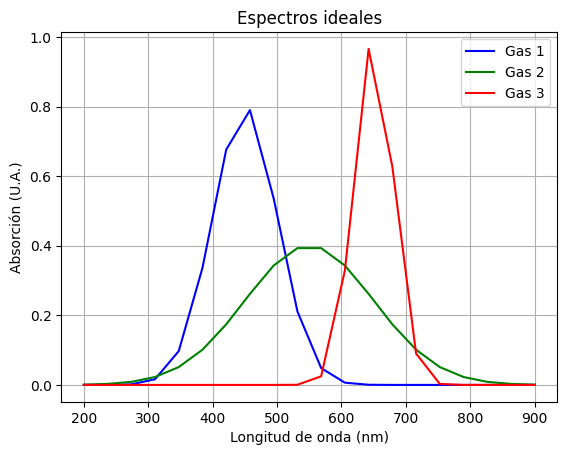

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# División de bandas espectrales
bandas = 20 
# Longitudes de onda en nanómetros (nm) para el espectro visible
long_onda = np.linspace(200, 900, bandas)

# Función para crear un espectro gaussiano ideal
def espectro_gaussiano(mu, sigma, amplitud=1.0):
    return amplitud * np.exp(-0.5 * ((long_onda - mu) / sigma) ** 2)

# Espectros ideales de absorción
gas1_espectro = espectro_gaussiano(mu=480, sigma=50, amplitud=.8) # Centrado en azul
gas2_espectro = espectro_gaussiano(mu=560, sigma=100, amplitud=.4) # Centrado en verde
gas3_espectro = espectro_gaussiano(mu=655, sigma=30) # Centrado en rojo

plt.plot(long_onda, gas1_espectro, label='Gas 1', c="blue")
plt.plot(long_onda, gas2_espectro, label='Gas 2', c="green")
plt.plot(long_onda, gas3_espectro, label='Gas 3', c="red")
plt.xlabel("Longitud de onda (nm)")
plt.ylabel("Absorción (U.A.)")
plt.title("Espectros ideales")
plt.legend()
plt.grid(True)
plt.show()

In [104]:
# Imágenes
alto, ancho = 10, 10
n_imagenes = 500
imagenes_gas1 = []
imagenes_gas2 = []
imagenes_gas3 = []

# Desviación porcentual para el ruido
desv_relativa = .4

def generar_imagen(espectro_base, alto, ancho, bandas, desv_relativa):
    imagen = np.zeros((alto, ancho, bandas))
    for i in range(alto):
        for j in range(ancho):
            ruido = np.random.normal(loc=0.0, scale=desv_relativa, size=bandas)
            espectro_pixel = espectro_base * (1 + ruido)
            imagen[i, j, :] = np.clip(espectro_pixel, 0, 1)
    return imagen

# Imágenes para cada gas
for _ in range(n_imagenes):
    img1 = generar_imagen(gas1_espectro, alto, ancho, bandas, desv_relativa)
    img2 = generar_imagen(gas2_espectro, alto, ancho, bandas, desv_relativa)
    img3 = generar_imagen(gas3_espectro, alto, ancho, bandas, desv_relativa)
    
    imagenes_gas1.append(img1)
    imagenes_gas2.append(img2)
    imagenes_gas3.append(img3)

print("Forma de una imagen de gas 1:", imagenes_gas1[0].shape)
print("Cantidad de imágenes generadas para gas 1:", len(imagenes_gas1))

Forma de una imagen de gas 1: (10, 10, 20)
Cantidad de imágenes generadas para gas 1: 500


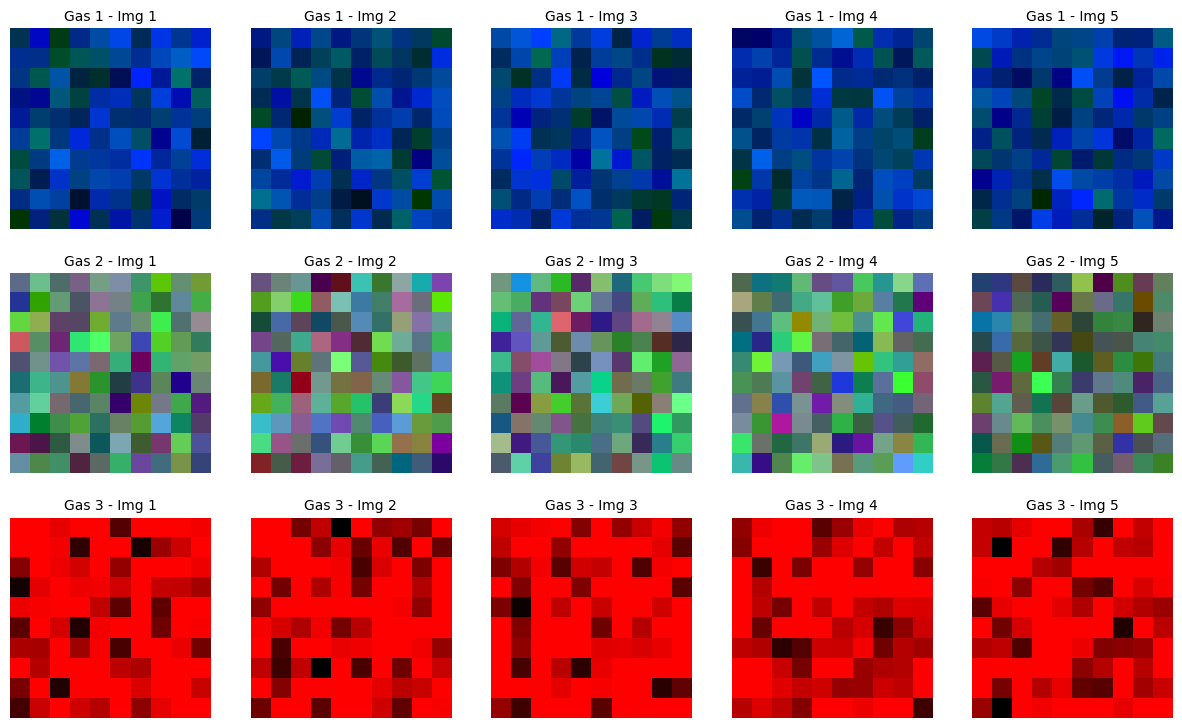

In [105]:
# Longitudes de onda centrales RGB
r = 655  
g = 550  
b = 480  

# Índices para canales RGB
r_band = np.argmin(np.abs(long_onda-r))
g_band = np.argmin(np.abs(long_onda-g))
b_band = np.argmin(np.abs(long_onda-b))

def convertir_a_rgb(imagen, r_band, g_band, b_band):
    rgb = np.stack([
        imagen[:, :, r_band],
        imagen[:, :, g_band],
        imagen[:, :, b_band]
    ], axis=2)
    # Normalizar entre 0 y 1
    rgb_min = rgb.min()
    rgb_max = rgb.max()
    rgb_norm = (rgb - rgb_min) / (rgb_max - rgb_min)
    return rgb_norm

n_plots = 5

fig, axs = plt.subplots(3, n_plots, figsize=(3*n_plots, 9))

#Gas 1 
for i in range(n_plots):
    rgb_img = convertir_a_rgb(imagenes_gas1[i], r_band, g_band, b_band)
    axs[0, i].imshow(rgb_img)
    axs[0, i].set_title(f"Gas 1 - Img {i+1}", fontsize=10)
    axs[0, i].axis("off")

#Gas 2
for i in range(n_plots):
    rgb_img = convertir_a_rgb(imagenes_gas2[i], r_band, g_band, b_band)
    axs[1, i].imshow(rgb_img)
    axs[1, i].set_title(f"Gas 2 - Img {i+1}", fontsize=10)
    axs[1, i].axis("off")

#Gas 3
for i in range(n_plots):
    rgb_img = convertir_a_rgb(imagenes_gas3[i], r_band, g_band, b_band)
    axs[2, i].imshow(rgb_img)
    axs[2, i].set_title(f"Gas 3 - Img {i+1}", fontsize=10)
    axs[2, i].axis("off")
plt.show()

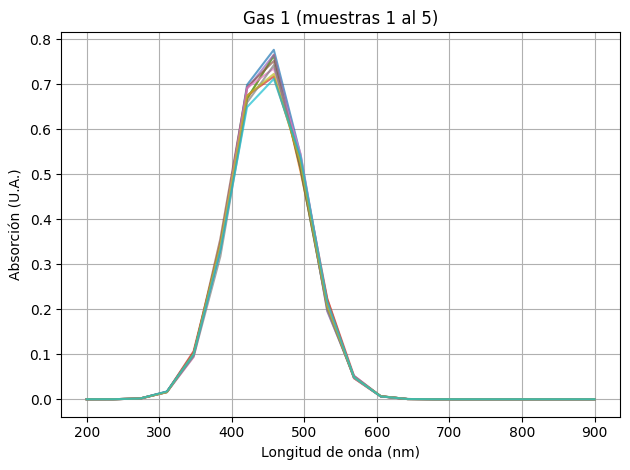

In [106]:
def calcular_espectro_promedio(imagenes):
    espectros_promedio = []
    for i in range(len(imagenes)):
        espectro_promedio_i = imagenes[i].mean(axis=(0, 1))
        espectros_promedio.append(espectro_promedio_i)
    return espectros_promedio

# Almaceno los espectros promedio de cada gas
gas1 = calcular_espectro_promedio(imagenes_gas1)
gas2 = calcular_espectro_promedio(imagenes_gas2)
gas3 = calcular_espectro_promedio(imagenes_gas3)

for i in range(10):
    plt.plot(long_onda, gas1[i], alpha=0.7)

plt.xlabel('Longitud de onda (nm)')
plt.ylabel('Absorción (U.A.)')
plt.title('Gas 1 (muestras 1 al 5)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [114]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

# Datos y clases
X = np.vstack([gas1, gas2, gas3])
y = np.array([0] * (n_imagenes) + [1] * (n_imagenes) + [2] * (n_imagenes)) # Por si los tamaños de las listas no son iguales
y_cat = to_categorical(y, num_classes=3)

# Dividir train/test
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.3)

# Modelo
model = Sequential([
    Dense(5, activation='relu', input_shape=(bandas,), name="Oculta"),
    Dense(5, activation='relu', name="Oculta2"),
    Dense(5, activation='relu', name="Oculta3"),
    Dense(3, activation='softmax', name="Salida")
])

model.compile(optimizer=Adam(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entrenar
history = model.fit(X_train, y_train, epochs=6, verbose=1, validation_data=(X_test, y_test))

# Evaluar
loss, acc = model.evaluate(X_test, y_test)
print(f'Accuracy en test: {acc:.2f}')

Epoch 1/6


c:\Users\facun\Desktop\ITBA\SD e IA\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5864 - loss: 0.9756 - val_accuracy: 1.0000 - val_loss: 0.5021
Epoch 2/6
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8849 - loss: 0.3880 - val_accuracy: 1.0000 - val_loss: 0.1296
Epoch 3/6
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0940 - val_accuracy: 1.0000 - val_loss: 0.0198
Epoch 4/6
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0138 - val_accuracy: 1.0000 - val_loss: 0.0043
Epoch 5/6
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0038 - val_accuracy: 1.0000 - val_loss: 0.0021
Epoch 6/6
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 0.0013
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0012 
Accuracy en test: 1.00


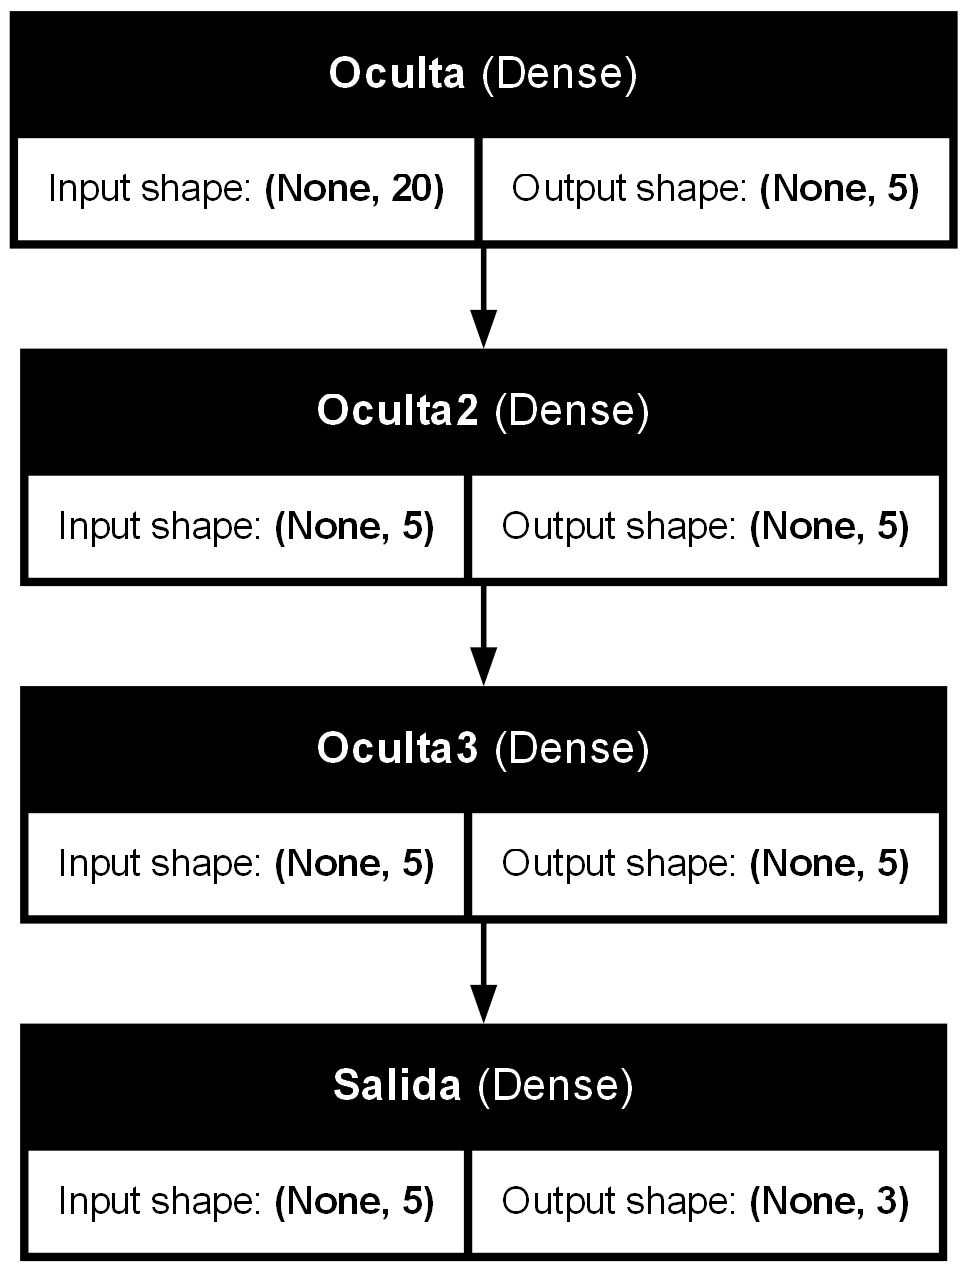

<Figure size 800x300 with 0 Axes>

In [115]:
from tensorflow.keras.utils import plot_model

plt.figure(figsize=(8, 3))
plot_model(model, show_shapes=True, show_layer_names=True)

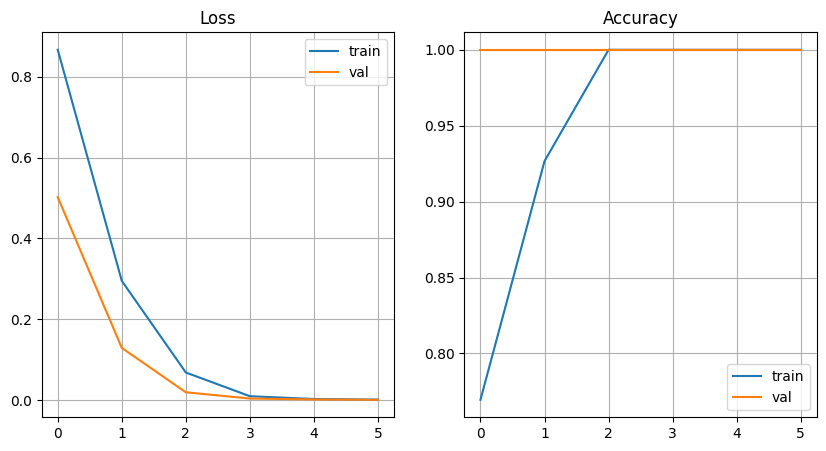

In [116]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Probabilidades por clase: [[9.9627101e-01 3.7188255e-03 1.0050174e-05]]
El modelo predice que es el gas número: 1


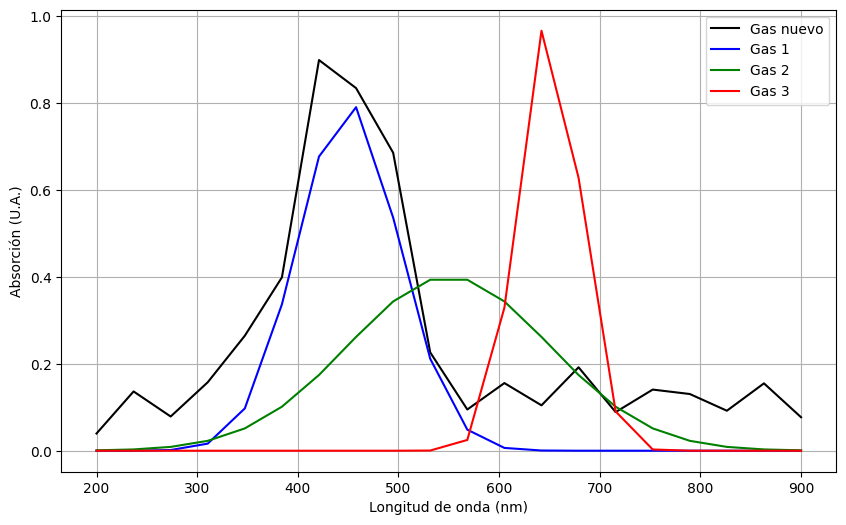

In [125]:
# Introduzco un nuevo gas con una firma espectral similar a gas1

nuevo_gas = gas1_espectro + .1 + 0.05 * np.random.randn(1, bandas)

# Predecir
pred_proba = model.predict(nuevo_gas, verbose=0)

# Mostrar vector de probabilidades
print("Probabilidades por clase:", pred_proba)

# Clase predicha (índice de la clase con mayor probabilidad)
pred_clase = np.argmax(pred_proba)
print(f"El modelo predice que es el gas número: {pred_clase+1}")

# Mostrar la firma espectral
plt.figure(figsize=(10, 6))
plt.plot(long_onda, nuevo_gas.flatten(), label="Gas nuevo", color='k')
plt.plot(long_onda, gas1_espectro, label='Gas 1', color='blue')
plt.plot(long_onda, gas2_espectro, label='Gas 2', color='green')
plt.plot(long_onda, gas3_espectro, label='Gas 3', color='red')
plt.xlabel("Longitud de onda (nm)")
plt.ylabel("Absorción (U.A.)")
plt.legend()
plt.grid(True)
plt.show()
